<a href="https://colab.research.google.com/github/TienDat11/report-big-data/blob/main/Case2_ThiCuoiKy_BigData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Clustering individuals as per their demographics

In this case study, we will use clustering methods to identify different types of investors.

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)
    * [4.3.Data Transformation](#3.2)  
* [5.Evaluate Algorithms and Models](#5)        
    * [5.1. k-Means Clustering](#5.1)
        * [5.1.1 Finding right number of clusters](#5.1.1)   
    * [5.2. Affinity Propagation Clustering](#5.2)
    * [5.3. Cluster Evaluation](#5.3)
* [6.Cluster Intuition](#6)     
    
    

<a id='0'></a>
# 1. Problem Definition

The goal of this case study is to build a machine learning model to cluster individuals/investors based on the parameters related to the ability and willingness to take risk. We will focus on using common demographic and financial characteristics to accomplish this.

For this case study the data used is from survey of Consumer Finances which is conducted by the Federal Reserve Board, which has been used in the case studies in chapter 5 and chapter 6.

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [1]:
# Tải các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime

# Nhập các gói mô hình phân cụm
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold


# Các gói và hàm hỗ trợ khác
import matplotlib.ticker as ticker
from itertools import cycle

<a id='1.2'></a>
## 2.2. Loading the Data

The dataset is same as the dataset used, which is further processed to give the following attributes for different investors for the year 2007.

In [2]:
# Tải tập dữ liệu từ file Excel
dataset = pd.read_excel('ProcessedData.xlsx')

In [3]:
# Tắt các cảnh báo
import warnings
warnings.filterwarnings('ignore')

In [4]:
type(dataset) # Kiểm tra kiểu dữ liệu của biến dataset

pandas.core.frame.DataFrame

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [5]:
# Hiển thị kích thước của tập dữ liệu (số hàng, số cột)
dataset.shape

(3866, 13)

In [6]:
# Xem qua 5 dòng dữ liệu đầu tiên
set_option('display.width', 100)
dataset.head(5)

,ID,AGE,EDUC,MARRIED,KIDS,LIFECL,OCCAT,RISK,HHOUSES,WSAVED,SPENDMOR,NWCAT,INCCL
0,1,3,2,1,0,2,1,3,1,1,5,3,4
1,2,4,4,1,2,5,2,3,0,2,5,5,5
2,3,3,1,1,2,3,2,2,1,2,4,4,4
3,4,3,1,1,2,3,2,2,1,2,4,3,4
4,5,4,3,1,1,5,1,2,1,3,3,5,5


As we can see in the table above, there are 12 attributes for each of the individuals. These attributes can be categorized as demographic, financial and behavioral attributes.

In [23]:
# Mô tả thống kê các cột trong tập dữ liệu
pd.set_option('display.precision', 3)
dataset.describe()

,ID,AGE,EDUC,MARRIED,KIDS,LIFECL,OCCAT,RISK,HHOUSES,WSAVED,SPENDMOR,NWCAT,INCCL
count,3866.000,3866.000,3866.000,3866.000,3866.000,3866.000,3866.000,3866.000,3866.000,3866.000,3866.000,3866.000,3866.000
mean,1933.500,3.107,2.906,1.353,0.938,3.697,1.742,3.043,0.717,2.446,3.561,2.976,3.671
std,1116.162,1.513,1.066,0.478,1.249,1.618,0.934,0.879,0.451,0.743,1.304,1.463,1.184
min,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000
25%,967.250,2.000,2.000,1.000,0.000,3.000,1.000,2.000,0.000,2.000,2.000,2.000,3.000
50%,1933.500,3.000,3.000,1.000,0.000,3.000,1.000,3.000,1.000,3.000,4.000,3.000,4.000
75%,2899.750,4.000,4.000,2.000,2.000,5.000,3.000,4.000,1.000,3.000,5.000,4.000,5.000
max,3866.000,6.000,4.000,2.000,8.000,6.000,4.000,4.000,1.000,3.000,5.000,5.000,5.000


<a id='2.2'></a>
## 3.2. Data Visualization

Let us look at the correlation. We will take a detailed look into the visualization post clustering.

<Axes: title={'center': 'Ma trận tương quan'}>

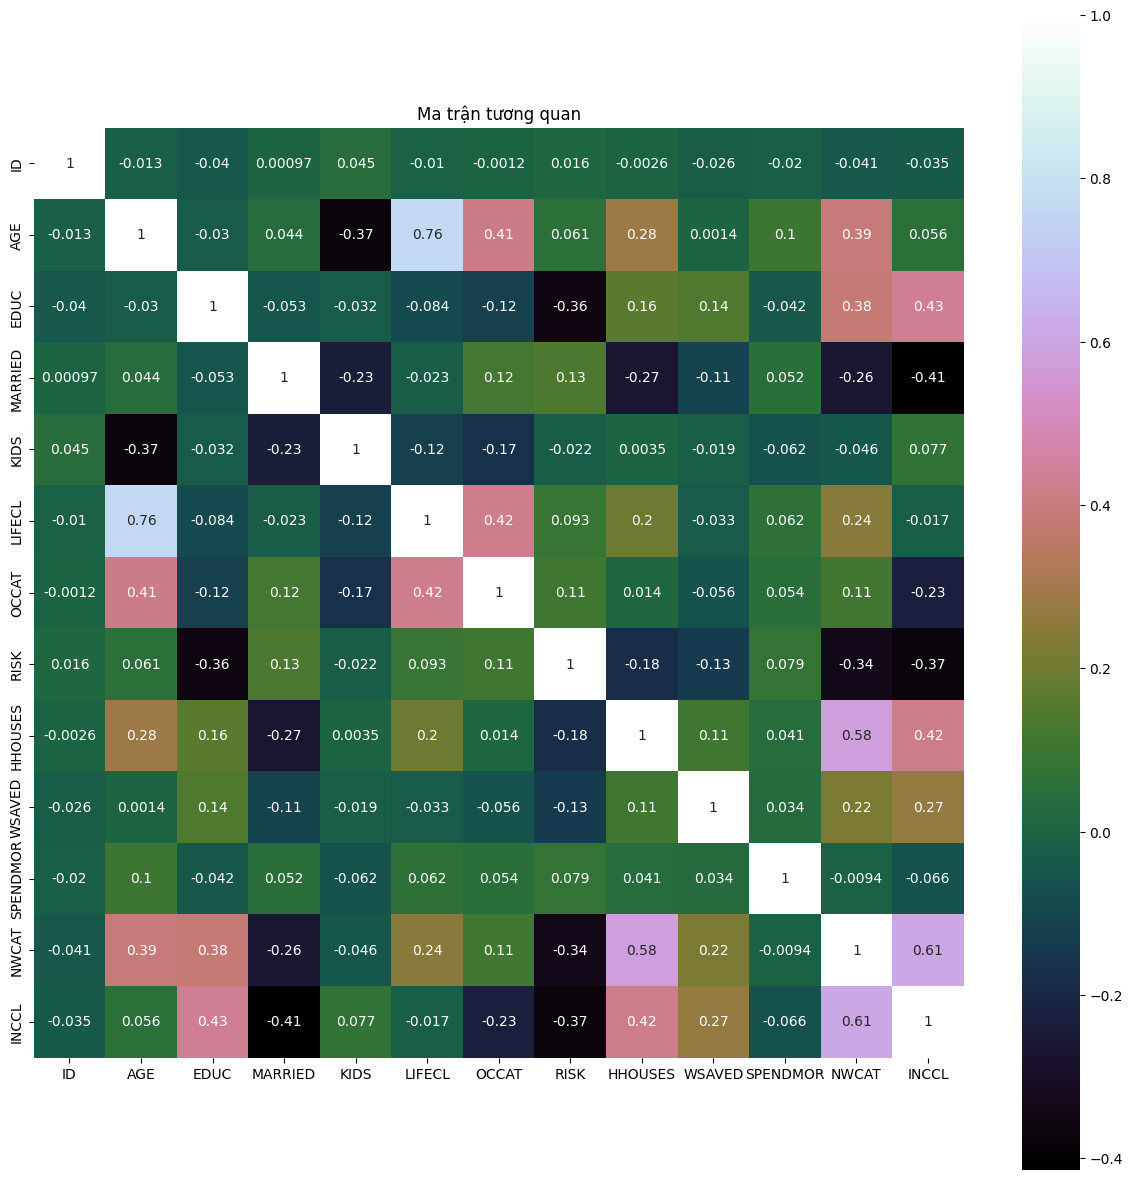

In [8]:
# Tính toán ma trận tương quan
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Ma trận tương quan') # Đặt tiêu đề cho biểu đồ
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

As it can be seen by the picture above there is a significant positive correlation between the stocks.

<a id='3'></a>
## 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning
Let us check for the NAs in the rows, either drop them or fill them with the mean of the column.

In [9]:
# Kiểm tra xem có bất kỳ giá trị rỗng nào trong tập dữ liệu hay không
print('Có giá trị rỗng =', dataset.isnull().values.any())

Có giá trị rỗng = False


Given there isn't any missing data and the data is already in the categorical format no further data cleaning was performed. The ID column which is not needed is dropeed

In [10]:
X = dataset.copy("deep") # Tạo một bản sao sâu của tập dữ liệu để làm việc
X = X.drop(['ID'], axis=1) # Loại bỏ cột 'ID' vì nó không cần thiết cho việc phân cụm
X.head() # Hiển thị 5 dòng dữ liệu đầu tiên sau khi loại bỏ cột 'ID'

,AGE,EDUC,MARRIED,KIDS,LIFECL,OCCAT,RISK,HHOUSES,WSAVED,SPENDMOR,NWCAT,INCCL
0,3,2,1,0,2,1,3,1,1,5,3,4
1,4,4,1,2,5,2,3,0,2,5,5,5
2,3,1,1,2,3,2,2,1,2,4,4,4
3,3,1,1,2,3,2,2,1,2,4,3,4
4,4,3,1,1,5,1,2,1,3,3,5,5


<a id='3.2'></a>
## 4.2. Data Transformation

The data available is comprised of attributes with similar scale. Hence no data transformation is required.

<a id='4'></a>
# 5. Evaluate Algorithms and Models

In this step, we will look at the following models and perform further analysis and visualization.

1. K-means
2. Affinity Propagation

<a id='5.1'></a>
## 5.1. K-Means Clustering


In this step we look at the following metrices to get the optimum number of clusters

1. Sum of square errors (SSE) within clusters
2. Silhouette score.

<a id='5.1.1'></a>
### 5.1.1. Finding optimal number of clusters

Typically, two metrics are used to evaluate the number of clusters in K-means model.

1. Sum of square errors (SSE) within clusters
2. Silhouette score


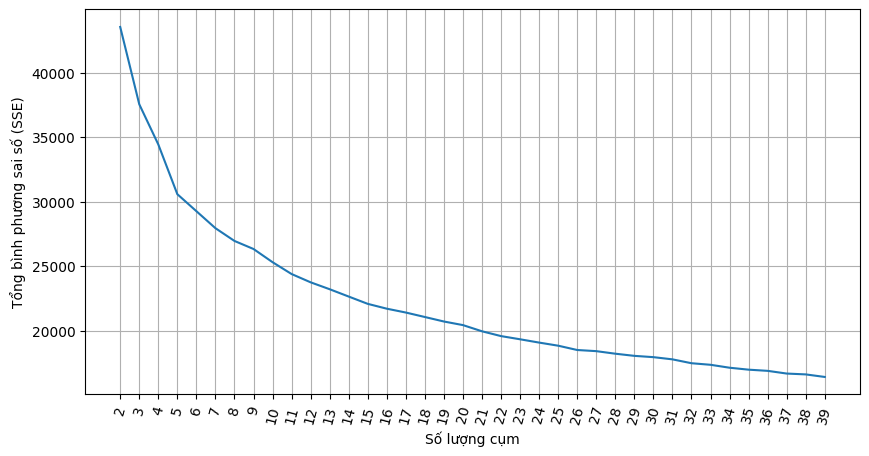

In [11]:
distorsions = [] # Danh sách lưu trữ tổng bình phương sai số
max_loop = 40 # Số lượng cụm tối đa để thử nghiệm
for k in range(2, max_loop): # Lặp từ 2 đến max_loop-1 cụm
    k_means = KMeans(n_clusters=k, random_state=42) # Khởi tạo mô hình KMeans với random_state để tái lập kết quả
    k_means.fit(X) # Huấn luyện mô hình với dữ liệu
    distorsions.append(k_means.inertia_) # Thêm SSE của cụm hiện tại vào danh sách
fig = plt.figure(figsize=(10, 5))
plt.plot(range(2, max_loop), distorsions) # Vẽ biểu đồ SSE theo số lượng cụm
plt.xticks([i for i in range(2, max_loop)], rotation=75) # Đặt nhãn trục x
plt.xlabel("Số lượng cụm") # Nhãn trục x
plt.ylabel("Tổng bình phương sai số (SSE)") # Nhãn trục y
plt.grid(True) # Hiển thị lưới

#### Silhouette score

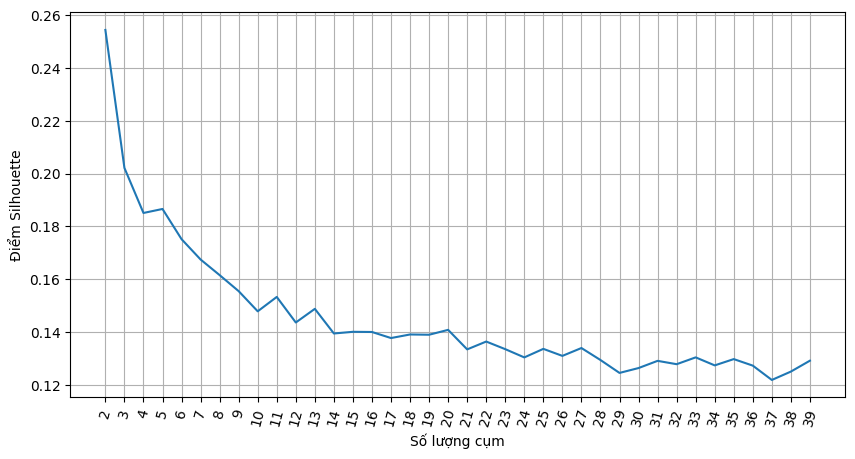

In [24]:
from sklearn import metrics

silhouette_scores = [] # Danh sách lưu trữ điểm Silhouette
for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10) # Khởi tạo mô hình KMeans
        kmeans.fit(X) # Huấn luyện mô hình
        silhouette_scores.append(metrics.silhouette_score(X, kmeans.labels_, random_state=10)) # Tính và lưu điểm Silhouette
fig = plt.figure(figsize=(10, 5))
plt.plot(range(2, max_loop), silhouette_scores) # Vẽ biểu đồ điểm Silhouette theo số lượng cụm
plt.xticks([i for i in range(2, max_loop)], rotation=75) # Đặt nhãn trục x
plt.xlabel("Số lượng cụm") # Nhãn trục x
plt.ylabel("Điểm Silhouette") # Nhãn trục y
plt.grid(True) # Hiển thị lưới

Looking at both the charts above, the optimum number of clusters seem to be around 7. We can see that as the number of clusters increase pass 6, the sum of square of
errors within clusters plateaus off. From the second graph, we can see that there are
various parts of the graph where a kink can be seen. Since there is not much a difference in SSE after 7 clusters, we would use 7 clusters in the k-means model below.

<a id='5.1.2'></a>
### 5.1.2. Clustering and Visualisation

In [13]:
nclust = 7 # Định nghĩa số lượng cụm tối ưu là 7

In [14]:
# Huấn luyện mô hình K-means với số cụm đã chọn
k_means = cluster.KMeans(n_clusters=nclust, random_state=42) # Khởi tạo KMeans với 7 cụm và random_state để đảm bảo tái lập kết quả
k_means.fit(X) # Huấn luyện mô hình với dữ liệu

KMeans(n_clusters=7, random_state=42)

In [15]:
# Trích xuất nhãn cụm cho mỗi điểm dữ liệu
target_labels = k_means.predict(X) # Dự đoán cụm cho từng điểm trong tập dữ liệu X

<a id='5.2'></a>
## 5.2. Affinity Propagation

In [16]:
ap = AffinityPropagation(damping=0.5, max_iter=250, affinity='euclidean', random_state=42) # Khởi tạo mô hình Affinity Propagation với random_state để đảm bảo tái lập kết quả
ap.fit(X) # Huấn luyện mô hình với dữ liệu
clust_labels2 = ap.predict(X) # Dự đoán nhãn cụm cho từng điểm dữ liệu

In [17]:
cluster_centers_indices = ap.cluster_centers_indices_ # Lấy chỉ số của các điểm đại diện cụm (exemplars)
labels = ap.labels_ # Lấy nhãn cụm cho mỗi điểm dữ liệu
n_clusters_ = len(cluster_centers_indices) # Tính số lượng cụm ước tính
print('Số lượng cụm ước tính: %d' % n_clusters_)

Số lượng cụm ước tính: 161


<a id='5.3'></a>
## 5.3. Cluster Evaluation

We evaluate the clusters using Silhouette Coefficient (sklearn.metrics.silhouette_score). Higher Silhouette Coefficient score means a model with better defined clusters.

In [18]:
from sklearn import metrics
print("K-Means Silhouette Score:", metrics.silhouette_score(X, k_means.labels_, metric='euclidean')) # In điểm Silhouette của K-Means
print("Affinity Propagation Silhouette Score:", metrics.silhouette_score(X, ap.labels_, metric='euclidean')) # In điểm Silhouette của Affinity Propagation

K-Means Silhouette Score: 0.17236277273780543
Affinity Propagation Silhouette Score: 0.09690483039906135


k-means has much higher Silhouette Coefficient as compared to the affinity propagation.

<a id='6'></a>
# 6. Cluster Intuition
In the next step, we will check each cluster and understand the intuition behind the clusters.

In [19]:
cluster_output = pd.concat([pd.DataFrame(X), pd.DataFrame(k_means.labels_, columns=['cluster'])], axis=1) # Ghép dữ liệu gốc với nhãn cụm
output = cluster_output.groupby('cluster').mean() # Tính giá trị trung bình của các thuộc tính cho mỗi cụm
output # Hiển thị kết quả

,AGE,EDUC,MARRIED,KIDS,LIFECL,OCCAT,RISK,HHOUSES,WSAVED,SPENDMOR,NWCAT,INCCL
cluster,,,,,,,,,,,,
0,2.483553,3.539474,1.095395,2.171053,3.138158,1.450658,2.506579,0.952303,2.684211,3.523026,4.189145,4.682566
1,4.826866,2.155224,1.574627,0.188060,5.613433,2.361194,3.546269,0.710448,2.267164,3.870149,2.367164,2.685075
2,1.922717,2.442623,1.285714,1.988290,3.299766,1.414520,3.271663,0.515222,2.206089,1.976581,1.784543,3.231850
3,1.795207,2.723312,1.629630,0.002179,1.372549,1.633987,3.226580,0.315904,2.379085,3.464052,1.516340,2.755991
4,4.673858,3.468274,1.225888,0.296954,5.355330,2.078680,2.748731,0.942893,2.629442,3.562183,4.522843,4.508883
5,2.407595,3.432911,1.422785,0.012658,1.589873,1.346835,2.711392,0.850633,2.615190,3.655696,3.683544,4.362025
6,1.907514,2.423892,1.321773,2.100193,3.344894,1.435453,3.369942,0.522158,2.246628,4.522158,1.726397,3.134875


### Demographics Features

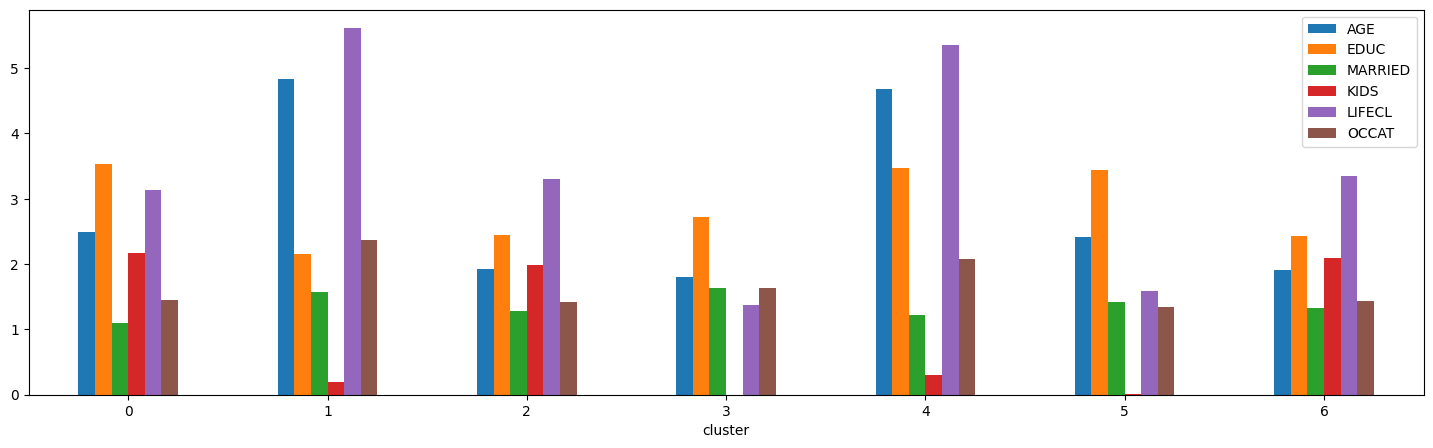

In [20]:
output[['AGE', 'EDUC', 'MARRIED', 'KIDS', 'LIFECL', 'OCCAT']].plot.bar(rot=0, figsize=(18,5)); # Vẽ biểu đồ cột giá trị trung bình các đặc điểm nhân khẩu học theo cụm

The plot here shows the average value of the attributes for each of the clusters. For
example, comparing cluster 0 and cluster 1, cluster 0 has lower average age, yet higher
average education. In terms of marriage and number of children, these two clusters
are similar. So, the individuals in cluster 0 will on an average have higher risk toler‐
ance as compared to the individuals in cluster 1, based on the demographic attributes.

### Financial Features and Features related to willingness to take risk

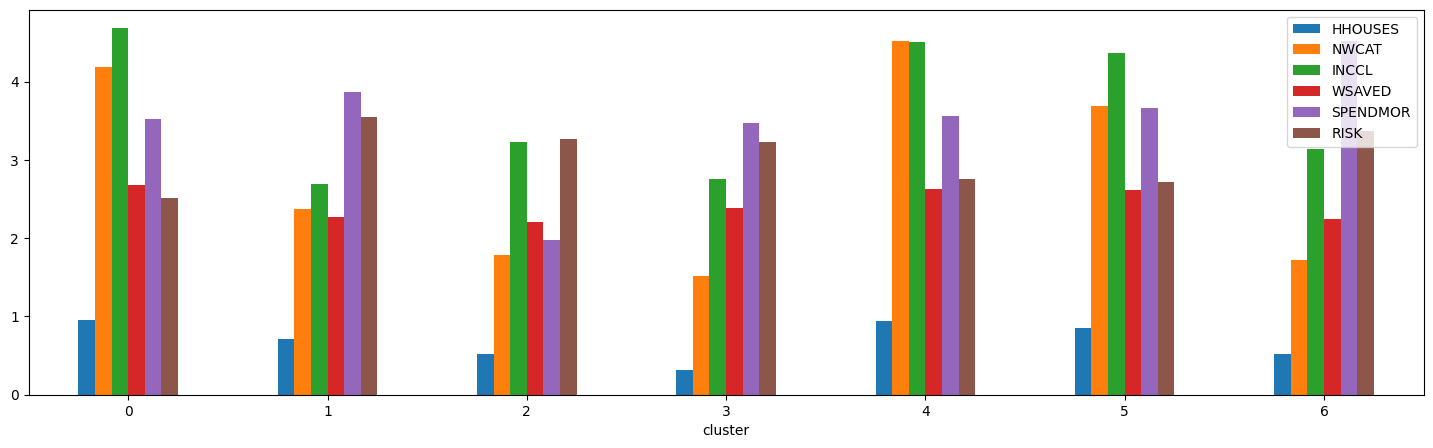

In [21]:
output[['HHOUSES', 'NWCAT', 'INCCL', 'WSAVED', 'SPENDMOR', 'RISK']].plot.bar(rot=0, figsize=(18,5)); # Vẽ biểu đồ cột giá trị trung bình các đặc điểm tài chính và rủi ro theo cụm

The plot here shows the average value of the attributes for each of the cluster on the
financial and behavioral attributes. For example, comparing cluster 0 and cluster 1,
cluster 0 has higher average house ownership, higher average net worth and income,
and a lower willingness to take risk. In terms of saving vs. income comparison and
willingness to save, the two clusters are comparable. Therefore, we can posit that the
individuals in cluster 0 will, on average, have a higher ability, yet lower willingness, to
take risk compared with cluster 1.

<Axes: xlabel='cluster'>

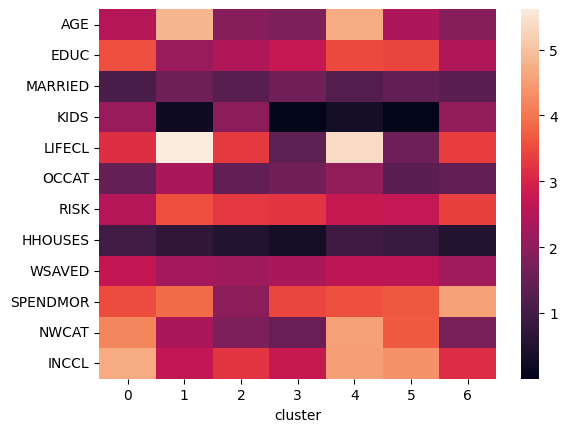

In [22]:
sns.heatmap(output.T) # Vẽ heatmap của ma trận transpose của output để dễ dàng so sánh các cụm

Combining the information from the demographics, financial, and behavioral
attributes for cluster 0 and cluster 1, the overall ability to take risk for individual clus‐
ter 0 is higher as compared to cluster 1. Performing similar analysis across all other
clusters, we summarize the results in the table below. The risk tolerance column rep‐
resents the subjective assessment of the risk tolerance of each of the clusters.

| Cluster| Features | Risk Capacity |
| --- | --- | --- |
| Cluster 0	 | Low Age, High Networth and Income, Less risky life category, willingness to spend more | High |
| Cluster 1	 | High Age, low net worth and Income, highly risky life category, Willing ness to take risk, low education | High |
| Cluster 2	 | High Age, high net worth and Income, highly risky life category, Willing ness to to take risk, own house | Medium |
| Cluster 3	 | 	Low age, very low income and net worth, high willingness to take risk, many kids | Low |
| Cluster 4	 | Medium age, very high income and net worth, high willingness to take risk, many kids, own house | High |
| Cluster 5	 | Low age, very low income and net worth, high willingness to take risk, no kids | Medium |
| Cluster 6	 | Low age, medium income and net worth, high willingness to take risk, many kids, own house | Low |


**_Conclusion_**

One of the key takeaways from this case study is the approach to understand the cluster intuition. We used visualization techniques to understand the expected behavior of a cluster member by qualitatively interpreting mean values of the variables in each
cluster.

We demonstrate the efficiency of the clustering technique in discovering the natural intuitive groups of different investors based on their risk tolerance.

Given, the clustering algorithms can successfully group investors based on different factors, such as age, income, and risk tolerance, it can further
used by portfolio managers to understand the investor’s behavior and standardize the portfolio allocation and rebalancing across the clusters, making the investment management process faster and effective.